# Boosting and the AdaBoost Method

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a better, final, prediction. 

In this lab you will work with widely used ensemble method known as **boosting**. Boosting is a meta-algorithm since the method can be applied to many types of machine learning algorithms. In summary, boosting iteratively improves the learning of the N models by giving greater weight to training cases with larger errors. The basic boosting procedure is simple and follows these steps:
1. N learners (machine learning models) are defined.
2. Each of i training data cases is given an initial equal weight of 1/i.
3. The N learners are trained on the weighted training data cases.
4. The prediction is computed based on a aggregation of the learners; averaging over the hypothesis of the N learners. 
5. Weights for the training data cases are updated based on the aggregated errors made by the learners. Cases with larger errors are given larger weights. 
6. Steps 3, 4, and 5 are repeated until a convergence criteria is met.

**Classification and regression tree models** are the weak learners most commonly used with boosting. In this lab you will work with one of the most widely used and successful boosted methods, known as **AdaBoost** or **adaptive boosting**. AdaBoost uses some large number, N, tree models. The rate at which weights are updated is **adaptive** with the errors. 

It is important to keep in mind that boosted machine learning is not robust to significant noise or outliers in the training data. The reweighting process gives greater weight to the large errors, and therefore can give undue weight to outliers and errors. In cases where data is noisy, the random forest algorithm may prove to be more robust. 

## Example: Iris dataset

As a first example you will use AdaBoost to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
from sklearn import datasets ## Get dataset from sklearn
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as nr

data_dir = './datasets/'

%matplotlib inline

To get a feel for these data, you will now load and plot them. The code in the cell below does the following:

1. Loads the iris data as a Pandas data frame. 
2. Adds column names to the data frame.
3. Displays all 4 possible scatter plot views of the data. 

Execute this code and examine the results. 

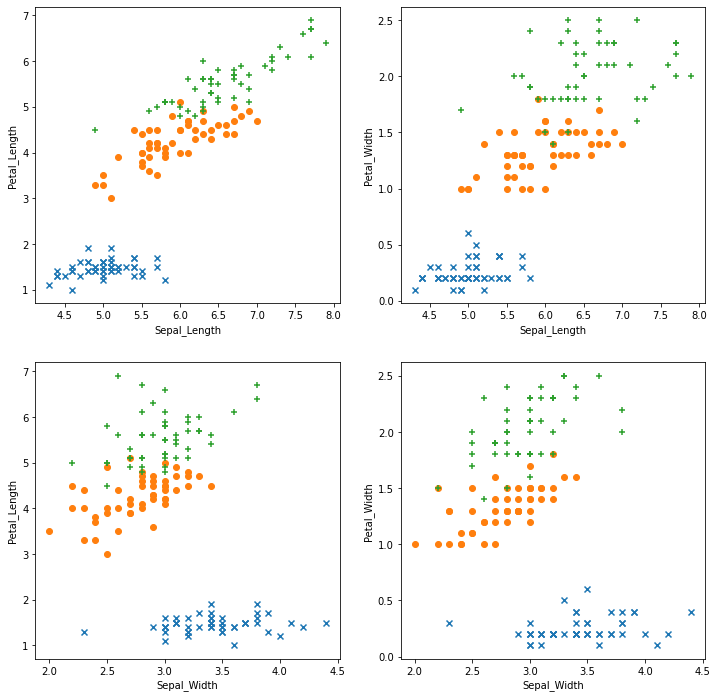

In [2]:
def plot_iris(iris):
    '''Function to plot iris data by type'''
    setosa = iris[iris['Species'] == 'setosa']
    versicolor = iris[iris['Species'] == 'versicolor']
    virginica = iris[iris['Species'] == 'virginica']
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    x_ax = ['Sepal_Length', 'Sepal_Width']
    y_ax = ['Petal_Length', 'Petal_Width']
    for i in range(2):
        for j in range(2):
            ax[i,j].scatter(setosa[x_ax[i]], setosa[y_ax[j]], marker = 'x')
            ax[i,j].scatter(versicolor[x_ax[i]], versicolor[y_ax[j]], marker = 'o')
            ax[i,j].scatter(virginica[x_ax[i]], virginica[y_ax[j]], marker = '+')
            ax[i,j].set_xlabel(x_ax[i])
            ax[i,j].set_ylabel(y_ax[j])
            
## Import the dataset from sklearn.datasets
iris = datasets.load_iris()

## Create a data frame from the dictionary
species = [iris.target_names[x] for x in iris.target]
iris = pd.DataFrame(iris['data'], columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
iris['Species'] = species

## Plot views of the iris data            
plot_iris(iris) 

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

Scikit Learn classifiers require numerically coded numpy arrays for the features and as a label. The code in the cell below does the following processing:
1. Creates a numpy array of the features.
2. Numerically codes the label using a dictionary lookup, and converts it to a numpy array. 

Execute this code.

In [3]:
Features = np.array(iris[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']])

levels = {'setosa':0, 'versicolor':1, 'virginica':2}
Labels =  np.array([levels[x] for x in iris['Species']])

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 100 of the 150 cases are being used as the test dataset. 

In [4]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

As is always the case with machine learning, numeric features  must be scaled. The code in the cell below performs the following processing:

1. A Zscore scale object is defined using the `StandarScaler` function from the Scikit Learn preprocessing package. 
2. The scaler is fit to the training features. Subsequently, this scaler is used to apply the same scaling to the test data and in production. 
3. The training features are scaled using the `transform` method. 

Execute this code.

In [5]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

Now you will define and fit an AdaBoosted tree model. The code in the cell below defines the model with 100 estimators (trees) using the `AdaBoostClassifer` function from the Scikit Learn ensemble  package, and then fits the model. Execute this code.

In [6]:
nr.seed(1115)
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)

AdaBoostClassifier()

Notice that the many hyperparameters of the AdaBoosted tree model object are displayed. 

Next, the code in the cell below performs the following processing to score the test data subset:
1. The test features are scaled using the scaler computed for the training features. 
2. The `predict` method is used to compute the scores from the scaled features. 

Execute this code. 

In [7]:
X_test = scale.transform(X_test)
scores = ab_clf.predict(X_test)

It is time to evaluate the model results. Keep in mind that the problem has been made deliberately difficult, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [8]:
def print_metrics_3(labels, scores):
   
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score Setosa   Score Versicolor    Score Virginica')
    print('Actual Setosa      %6d' % conf[0,0] + '            %5d' % conf[0,1] + '             %5d' % conf[0,2])
    print('Actual Versicolor  %6d' % conf[1,0] + '            %5d' % conf[1,1] + '             %5d' % conf[1,2])
    print('Actual Vriginica   %6d' % conf[2,0] + '            %5d' % conf[2,1] + '             %5d' % conf[2,2])
    ## Now compute and display the accuracy and metrics
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    print(' ')
    print('          Setosa  Versicolor  Virginica')
    print('Num case   %0.2f' % metrics[3][0] + '     %0.2f' % metrics[3][1] + '      %0.2f' % metrics[3][2])
    print('Precision   %0.2f' % metrics[0][0] + '      %0.2f' % metrics[0][1] + '       %0.2f' % metrics[0][2])
    print('Recall      %0.2f' % metrics[1][0] + '      %0.2f' % metrics[1][1] + '       %0.2f' % metrics[1][2])
    print('F1          %0.2f' % metrics[2][0] + '      %0.2f' % metrics[2][1] + '       %0.2f' % metrics[2][2])
    
print_metrics_3(y_test, scores)    

                 Confusion matrix
                 Score Setosa   Score Versicolor    Score Virginica
Actual Setosa          35                0                 0
Actual Versicolor       0               32                 2
Actual Vriginica        0                3                28

Accuracy        0.95
 
          Setosa  Versicolor  Virginica
Num case   35.00     34.00      31.00
Precision   1.00      0.91       0.93
Recall      1.00      0.94       0.90
F1          1.00      0.93       0.92


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.95. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.

To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

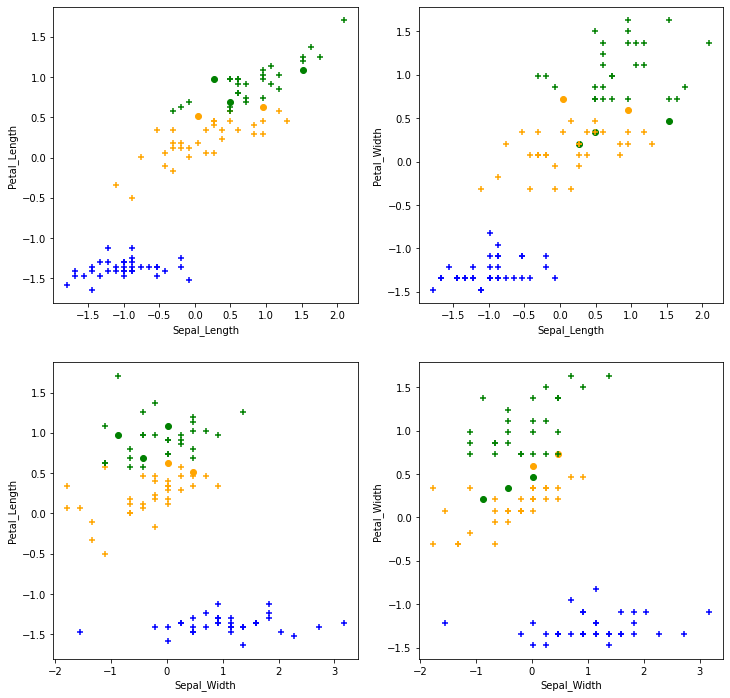

In [9]:
def plot_iris_score(iris, y_test, scores):
    '''Function to plot iris data by type'''
    ## Find correctly and incorrectly classified cases
    true = np.equal(scores, y_test).astype(int)
    
    ## Create data frame from the test data
    iris = pd.DataFrame(iris)
    levels = {0:'setosa', 1:'versicolor', 2:'virginica'}
    iris['Species'] = [levels[x] for x in y_test]
    iris.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']
    
    ## Set up for the plot
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    markers = ['o', '+']
    x_ax = ['Sepal_Length', 'Sepal_Width']
    y_ax = ['Petal_Length', 'Petal_Width']
    
    for t in range(2): # loop over correct and incorect classifications
        setosa = iris[(iris['Species'] == 'setosa') & (true == t)]
        versicolor = iris[(iris['Species'] == 'versicolor') & (true == t)]
        virginica = iris[(iris['Species'] == 'virginica') & (true == t)]
        # loop over all the dimensions
        for i in range(2):
            for j in range(2):
                ax[i,j].scatter(setosa[x_ax[i]], setosa[y_ax[j]], marker = markers[t], color = 'blue')
                ax[i,j].scatter(versicolor[x_ax[i]], versicolor[y_ax[j]], marker = markers[t], color = 'orange')
                ax[i,j].scatter(virginica[x_ax[i]], virginica[y_ax[j]], marker = markers[t], color = 'green')
                ax[i,j].set_xlabel(x_ax[i])
                ax[i,j].set_ylabel(y_ax[j])

plot_iris_score(X_test, y_test, scores)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

Like most tree-based models, Ada Boosted tree models have a nice property that **feature importance** is computed during model training. Feature importance can be used as a feature selection method. 

Execute the code in the cell below to display a plot of the feature importance.

Text(0, 0.5, 'Feature importance')

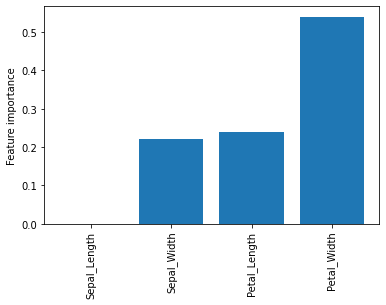

In [10]:
importance = ab_clf.feature_importances_
plt.bar(range(4), importance, tick_label = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')

Examine the plot displayed above. Notice that the Sepal_Lenght has virtually no importance. 

Should this feature be dropped from the model? To find out, you will create a model with a reduced feature set and compare the results. As a first step, execute the code in the cell below to create training and test datasets using the reduced features.

In [11]:
## Create reduced feature set
Features = np.array(iris[['Sepal_Width', 'Petal_Length', 'Petal_Width']])

## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

Next, execute the code in the cell below to define the model, fit the model, score the model and print the results. 

Once you have executed the code, answer **Question 1** on the course page.

In [12]:
nr.seed(1115)
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
scores = ab_clf.predict(X_test)
print_metrics_3(y_test, scores) 

                 Confusion matrix
                 Score Setosa   Score Versicolor    Score Virginica
Actual Setosa          35                0                 0
Actual Versicolor       0               32                 2
Actual Vriginica        0                3                28

Accuracy        0.95
 
          Setosa  Versicolor  Virginica
Num case   35.00     34.00      31.00
Precision   1.00      0.91       0.93
Recall      1.00      0.94       0.90
F1          1.00      0.93       0.92


These results are identical to those obtained with the full feature set. In all likelihood, there is no significant difference. Given that a simpler model is more likely to generalize, this model is preferred. 

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which had the the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 
3. Encoding categorical variables as binary dummy variables.
4. Standardizing numeric variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [13]:
Features = np.array(pd.read_csv(data_dir+'Credit_Features.csv'))
Labels = np.array(pd.read_csv(data_dir+'Credit_Labels.csv'))
Labels = Labels.reshape(Labels.shape[0],)
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000,)


Nested cross validation is used to estimate the optimal hyperparameters and perform model selection for the AdaBoosted tree model. Since AdaBoosted tree models are efficient to train, 10 fold cross validation is used. Execute the code in the cell below to define inside and outside fold objects. 

In [14]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

The code in the cell below estimates the best hyperparameters using 10 fold cross validation. There are a few points to notice here:
1. In this case, a grid of one hyperparameter is searched: 
  - learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators
2. There is a class imbalance and a difference in the cost to the bank of misclassification of a bad credit risk customer. This will be addressed later. 
3. The model is fit on each set of hyperparameters from the grid. 
4. The best estimated hyperparameters are printed. 

Notice that the model uses regularization rather than feature selection. The hyperparameter search is intended to optimize the level of regularization. 

Execute this code, examine the result, and answer **Question 2** on the course page. 

In [15]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"learning_rate": [0.1, 1, 10]}
## Define the AdaBoosted tree model
nr.seed(3456)
ab_clf = AdaBoostClassifier()  

## Perform the grid search over the parameters
nr.seed(4455)
ab_clf = ms.GridSearchCV(estimator = ab_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
ab_clf.fit(Features, Labels)
print(ab_clf.best_estimator_.learning_rate)

1


Now, you will run the code in the cell below to perform the outer cross validation of the model. 

In [16]:
nr.seed(498)
cv_estimate = ms.cross_val_score(ab_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.758
SDT of the metric       = 0.034
Outcomes by cv fold
Fold  1    0.765
Fold  2    0.721
Fold  3    0.704
Fold  4    0.736
Fold  5    0.788
Fold  6    0.772
Fold  7    0.728
Fold  8    0.827
Fold  9    0.765
Fold 10    0.771


Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing datasets.

In [17]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

The code in the cell below defines an AdaBoosted tree model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [18]:
nr.seed(1115)
ab_mod = AdaBoostClassifier(learning_rate = ab_clf.best_estimator_.learning_rate) 
ab_mod.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1)

As expected, the hyperparameters of the AdaBoosted tree model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. Execute this code and examine the results. 

In [19]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    
probabilities = ab_mod.predict_proba(X_test)
print_metrics(y_test, probabilities, 0.5)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       176                36
Actual negative        45                43

Accuracy        0.73
AUC             0.76
Macro precision 0.67
Macro recall    0.66
 
           Positive      Negative
Num case      212            88
Precision    0.80          0.54
Recall       0.83          0.49
F1           0.81          0.51


Overall, these performance metrics are poor. The majority of negative cases have been misclassified as positive. Adaboosted methods are sensitive to class imbalance. 

It is likely that the poor performance arises from the class imbalance. Notice that there is no way to reweight classes with boosting methods. Some alternatives are:
1. **Impute** new values using a statistical algorithm. 
2. **Undersample** the majority cases. For this method a number of the cases equal to the minority case are Bernoulli sampled from the majority case. 
3. **Oversample** the minority cases. For this method the number of minority cases are resampled until they equal the number of majority cases.

The code in the cell below undersamples the majority cases; good credit customers. The `choice` function from the numpy.random package is used to randomize the undersampling. The count of unique label values and the shape of the resulting arrays is printed. Execute this code to create a data set with balanced cases. 

In [20]:
temp_Labels_1 = Labels[Labels == 1]  # Save these
temp_Features_1 = Features[Labels == 1,:] # Save these
temp_Labels_0 = Labels[Labels == 0]  # Undersample these
temp_Features_0 = Features[Labels == 0,:] # Undersample these

indx = nr.choice(temp_Features_0.shape[0], temp_Features_1.shape[0], replace=True)

temp_Features = np.concatenate((temp_Features_1, temp_Features_0[indx,:]), axis = 0)
temp_Labels = np.concatenate((temp_Labels_1, temp_Labels_0[indx,]), axis = 0) 

print(np.bincount(temp_Labels))
print(temp_Features.shape)
print(temp_Labels.shape)

[300 300]
(600, 35)
(600,)


There are now 300 of each label case with 600 cases overall. The question is, will using these data produce better results?

You will perform model selection and evaluation using nested cross validation. The code in the cell below finds the optimal learning rate parameter using cross validation. 

Once you have executed the code, answer **Question 3** on the course page.

In [21]:
nr.seed(1234)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(3214)
outside = ms.KFold(n_splits=10, shuffle = True)

## Define the AdaBoosted tree model
nr.seed(3456)
ab_clf = AdaBoostClassifier()  

## Perform the grid search over the parameters
nr.seed(4455)
ab_clf = ms.GridSearchCV(estimator = ab_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
ab_clf.fit(temp_Features, temp_Labels)
print(ab_clf.best_estimator_.learning_rate)

0.1


Notice that the estimated optimal learning rate parameter is smaller than before.

Now, run the code in the cell below to execute the outer loop of the cross validation. 

In [22]:
nr.seed(498)
cv_estimate = ms.cross_val_score(ab_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.758
SDT of the metric       = 0.034
Outcomes by cv fold
Fold  1    0.765
Fold  2    0.721
Fold  3    0.704
Fold  4    0.736
Fold  5    0.788
Fold  6    0.772
Fold  7    0.728
Fold  8    0.827
Fold  9    0.765
Fold 10    0.771


The average AUC is improved compared to the imbalanced training cases. However, the differences are just within 1 standard deviation. Still, there is a reasonable chance the new results represent an improvement. 

Finally, you will train and evaluate a model with the balanced cases and the update hyperparameter. The code in the cell below does the following processing:
1. Creates Bernoulli sampled test and training subsets. 
2. Defines an AdaBoosted model.
3. Trains the AdaBoosted model.

Execute this code. 

In [23]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Undersample the majority case for the training data
temp_Labels_1 = y_train[y_train == 1]  # Save these
temp_Features_1 = X_train[y_train == 1,:] # Save these
temp_Labels_0 = y_train[y_train == 0]  # Undersample these
temp_Features_0 = X_train[y_train == 0,:] # Undersample these

indx = nr.choice(temp_Features_0.shape[0], temp_Features_1.shape[0], replace=True)

X_train = np.concatenate((temp_Features_1, temp_Features_0[indx,:]), axis = 0)
y_train = np.concatenate((temp_Labels_1, temp_Labels_0[indx,]), axis = 0) 

print(np.bincount(y_train))
print(X_train.shape)
print(y_train.shape)

[212 212]
(424, 35)
(424,)


In [24]:
## Define and fit the model
nr.seed(1115)
ab_mod = AdaBoostClassifier(learning_rate = ab_clf.best_estimator_.learning_rate) 
ab_mod.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1)

Now, execute the code in the cell below to score and evaluate the model.

Once you have executed the code, answer **Question 4** on the course page.

In [25]:
probabilities = ab_mod.predict_proba(X_test)
print_metrics(y_test, probabilities, 0.5)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       146                66
Actual negative        19                69

Accuracy        0.72
AUC             0.79
Macro precision 0.70
Macro recall    0.74
 
           Positive      Negative
Num case      212            88
Precision    0.88          0.51
Recall       0.69          0.78
F1           0.77          0.62


These results are significantly better than those obtained with the imbalanced training data in classifying the negative cases. 

## Summary

In this lab you have accomplished the following:
1. Used an AdaBoosted tree model to classify the cases of the iris data. This model produced quite good results.
2. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
3. Used 10 fold to find estimated optimal hyperparameters for an AdaBoosted tree model to classify credit risk cases. The model did not generalize well.
4. Applied undersampling of the majority cases to create a balanced training dataset and retrained and evaluated the model. The model created with balanced training data was significantly better. 